In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# To load mnist data
import mnist

### Define VAE Model

In [2]:
def xavier_init(channel_in, channel_out, constant = 1): 
    """
    Xavier initialization of network weights
    """
    
    low = -constant * np.sqrt(6.0 / (channel_in + channel_out)) 
    high = constant * np.sqrt(6.0 / (channel_in + channel_out))
    return tf.random_uniform((channel_in, channel_out), minval = low, maxval = high, dtype=tf.float32)

In [3]:
class VAE(object):
    
    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        """
        Set up the VAE model.
        """
        
        # Set model parameters
        self.network_architecture = network_architecture
        self.lr = learning_rate
        self.batch_size = batch_size
        
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Forward pass
        self.forward()
        
        # Backward pass
        self.backward()

        # Initialize the variables and launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
    def initialize_weights(self, n_hidden_enc_1, n_hidden_enc_2, 
                           n_hidden_dec_1, n_hidden_dec_2, n_input, n_z):
        """
        Initialize weights of the network layers.
        """
        
        network_weights = dict()
        network_weights['encoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_input, n_hidden_enc_1)),
            'W2': tf.Variable(xavier_init(n_hidden_enc_1, n_hidden_enc_2)),
            'W_mu': tf.Variable(xavier_init(n_hidden_enc_2, n_z)),
            'W_logvar': tf.Variable(xavier_init(n_hidden_enc_2, n_z))}
        network_weights['encoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_enc_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_enc_2], dtype=tf.float32)),
            'b_mu': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'b_logvar': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        network_weights['decoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_z, n_hidden_dec_1)),
            'W2': tf.Variable(xavier_init(n_hidden_dec_1, n_hidden_dec_2)),
            'W_out': tf.Variable(xavier_init(n_hidden_dec_2, n_input))}
        network_weights['decoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_dec_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_dec_2], dtype=tf.float32)),
            'b_out': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return network_weights
 

    def encode(self, weights, bias):
        """
        Use the encoder model to map the input data to the latent space.
        """
        
        hidden_1 = tf.nn.relu(tf.add(tf.matmul(self.x, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        mu = tf.add(tf.matmul(hidden_2, weights['W_mu']), bias['b_mu'])
        logvar = tf.add(tf.matmul(hidden_2, weights['W_logvar']), bias['b_logvar'])
        return (mu, logvar)

    def decode(self, weights, bias):
        """
        Use the decoder model to reconstruct the input data.
        """
        
        hidden_1 = tf.nn.leaky_relu(tf.add(tf.matmul(self.z, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        recon_x = tf.nn.sigmoid(tf.add(tf.matmul(hidden_2, weights['W_out']), bias['b_out']))
        return recon_x
    
    
    def forward(self):
        """
        Build the VAE network.
        """
        
        # Initialize weights and bias
        network_weights = self.initialize_weights(**self.network_architecture)

        # Use encoder model to obtain latent z
        self.mu, self.logvar = self.encode(network_weights["encoder_weights"], 
                                      network_weights["encoder_bias"])

        # Draw sample z from Gaussian using reparametrization trick
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.mu, tf.multiply(tf.sqrt(tf.exp(self.logvar)), eps))

        # Use decoder model to obtain the reconstructed input
        self.recon_x = self.decode(network_weights["decoder_weights"],
                                    network_weights["decoder_bias"])
            
            
    def backward(self):
        """
        Calculate gradients using backpropagation and update weights using Adam optimizer.
        """
        
        rec_loss = - tf.reduce_sum(self.x * tf.log(1e-8 + self.recon_x)
                           + (1 - self.x) * tf.log(1e-8 + 1 - self.recon_x), 1)
      
        kl = -0.5 * tf.reduce_sum(1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar), 1)
        
        self.loss = tf.reduce_mean(rec_loss + kl)   
       
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss)
        
    def train(self, X):
        """
        Train model based on mini-batch of input data.
        Return loss of mini-batch.
        """
        
        opt, loss = self.sess.run((self.optimizer, self.loss), 
                                                feed_dict={self.x: X})
        return loss
    
    def transform(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run((self.mu, self.logvar), feed_dict={self.x: X})
    
    def generate(self, mu = None):
        """ 
        Generate data by sampling from the latent space.        
        """
        if mu is None:
            # Data is alternatively generated from the prior in the latent space
            mu = np.random.normal(size = self.network_architecture["n_z"])

        return self.sess.run(self.recon_x, feed_dict={self.z: mu})
    
    def reconstruct(self, X):
        """ 
        Reconstruct the given input data. 
        """
        
        return self.sess.run(self.recon_x, feed_dict={self.x: X})

### Applications on MNIST

In [4]:
def train_mnist(network_architecture, images,
                learning_rate=0.001, batch_size=100, n_epoch=10):
    """
    Train the VAE model on the MNIST data set.
    """
    
    vae = VAE(network_architecture, learning_rate=learning_rate, batch_size=batch_size)
    
    #images = mnist.train_images() 
    train_size = len(images)
    train_data = images.reshape((train_size, 784)) / 255 # normalize to [0,1]
    
    for epoch in range(n_epoch):
        
        avg_loss = 0.
        n_batch = int(train_size / batch_size) 

        for idx in range(n_batch):
            train_batch = train_data[idx * batch_size:idx * batch_size + batch_size]
            loss = vae.train(train_batch)
            avg_loss += loss / train_size * batch_size

        print("Epoch:", "%d/%d" % (epoch+1, n_epoch), 
              "Loss =", "{:.4f}".format(avg_loss))
        
    return vae

In [5]:
network_architecture = dict(n_hidden_enc_1=500, 
                             n_hidden_enc_2=500, 
                             n_hidden_dec_1=500, 
                             n_hidden_dec_2=500, 
                             n_input=784, 
                             n_z=2) 

vae_2d = train_mnist(network_architecture, mnist.train_images(), n_epoch = 20)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch: 1/20 Loss = 187.1380
Epoch: 2/20 Loss = 166.1935
Epoch: 3/20 Loss = 160.4723
Epoch: 4/20 Loss = 156.8319
Epoch: 5/20 Loss = 154.6106
Epoch: 6/20 Loss = 152.9814
Epoch: 7/20 Loss = 151.8122
Epoch: 8/20 Loss = 150.8295
Epoch: 9/20 Loss = 149.5667
Epoch: 10/20 Loss = 148.8187
Epoch: 11/20 Loss = 148.1064
Epoch: 12/20 Loss = 147.3902
Epoch: 13/20 Loss = 146.9144
Epoch: 14/20 Loss = 146.4995
Epoch: 15/20 Loss = 145.9047
Epoch: 16/20 Loss = 145.5568
Epoch: 17/20 Loss = 145.6178
Epoch: 18/20 Loss = 145.0207
Epoch: 19/20 Loss = 144.6445
Epoch: 20/20 Loss = 144.0981


#### Visualize reconstructed images

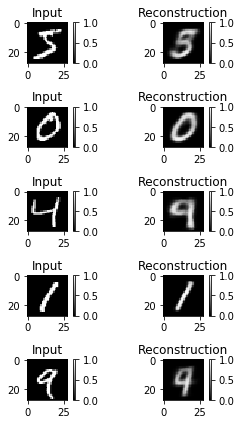

In [10]:
images = mnist.train_images()
x_sample = (images.reshape((60000, 784)) / 255)[:100,]
recon_x = vae_2d.reconstruct(x_sample)

plt.figure(figsize=(4, 6))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(recon_x[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

#### Visualize latent manifold

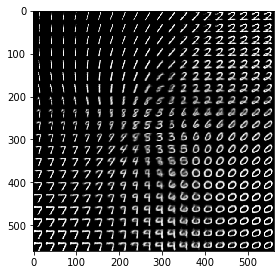

In [11]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae_2d.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(4, 5))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

#### Visualize 2D latent space

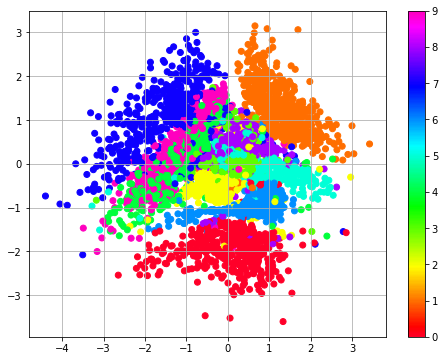

In [196]:
images = mnist.train_images()
labels = mnist.train_labels()
x_sample = (images.reshape((60000, 784)) / 255)[:5000,]
y_sample = labels[:5000]
z_mu = vae_2d.transform1d(x_sample)
cm = plt.cm.get_cmap('gist_rainbow')
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample, cmap=cm)
plt.colorbar()
plt.grid()

### Estimate ELBO
- For different dimensionality

In [7]:
def calculate_elbo(model, X, recon_X):
    """
    Compute the ELBO of the model with reconstruction error and KL divergence..
    """
    rec_loss = - np.sum(X * np.log(1e-8 + recon_X)
                           + (1 - X) * np.log(1e-8 + 1 - recon_X), 1)
    mu, logvar = model.transform(X)
    kl = -0.5 * np.sum(1 + logvar - mu ** 2 - np.exp(logvar), 1)
    elbo = np.mean(rec_loss + kl)
    return elbo

In [8]:
def train_mnist_elbo(network_architecture, train_images, test_images,
                learning_rate=0.001, batch_size=100, n_epoch=10):
    """
    Train the VAE model on the MNIST data set.
    """

    # Instantiate the model
    vae = VAE(network_architecture, learning_rate=learning_rate, batch_size=batch_size)

    # Load mnist data
    train_size = len(train_images)
    train_data = train_images.reshape((train_size, 784)) / 255 # normalize to [0,1]
    test_size = len(test_images)
    test_data = test_images.reshape((test_size, 784)) / 255 # normalize to [0,1]

    # Record keeping
    train_elbo_lst = []
    test_elbo_lst = []

    for epoch in range(n_epoch):

        train_loss = 0.
        test_loss = 0.
        n_train_batch = train_size // batch_size
        n_test_batch = test_size // batch_size

        # Train in mini-batches
        for idx in range(n_train_batch):
            train_batch = train_data[idx * batch_size:idx * batch_size + batch_size]
            loss = vae.train(train_batch)
            train_loss += loss
    
        # Test in mini-batches
        for idx in range(n_test_batch):
            test_batch = test_data[idx * batch_size:idx * batch_size + batch_size]
            recon_batch = vae.reconstruct(test_batch)
            loss = calculate_elbo(vae, test_batch, recon_batch)
            test_loss += loss
        
        train_elbo_lst.append(train_loss / n_train_batch)
        test_elbo_lst.append(test_loss / n_test_batch)

        print("Epoch:", "%d/%d" % (epoch+1, n_epoch),
              "Train Loss =", "{:.4f}".format(train_loss / n_train_batch),
              "Test Loss =", "{:.4f}".format(test_loss / n_test_batch))

    return vae, train_elbo_lst, test_elbo_lst

For a latend dimension of 3:

In [11]:
network_architecture = dict(n_hidden_enc_1=500, 
                             n_hidden_enc_2=500, 
                             n_hidden_dec_1=500, 
                             n_hidden_dec_2=500, 
                             n_input=784, 
                             n_z=3) 

vae, train_elbo_lst, test_elbo_lst = train_mnist_elbo(network_architecture, mnist.train_images(), 
                                                      mnist.test_images(), n_epoch = 100)

/Users/yizizhang/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 1/100 Train Loss = 175.0786 Test Loss = 157.8556
Epoch: 2/100 Train Loss = 151.1029 Test Loss = 152.0455
Epoch: 3/100 Train Loss = 146.3412 Test Loss = 148.4923
Epoch: 4/100 Train Loss = 143.4157 Test Loss = 145.4611
Epoch: 5/100 Train Loss = 141.3145 Test Loss = 143.2334
Epoch: 6/100 Train Loss = 139.8215 Test Loss = 142.4885
Epoch: 7/100 Train Loss = 138.5223 Test Loss = 140.7255
Epoch: 8/100 Train Loss = 137.4715 Test Loss = 139.6774
Epoch: 9/100 Train Loss = 136.5103 Test Loss = 139.5400
Epoch: 10/100 Train Loss = 135.7280 Test Loss = 138.5074
Epoch: 11/100 Train Loss = 135.0425 Test Loss = 137.9212
Epoch: 12/100 Train Loss = 134.3862 Test Loss = 137.5260
Epoch: 13/100 Train Loss = 133.8326 Test Loss = 137.4964
Epoch: 14/100 Train Loss = 133.3751 Test Loss = 137.4739
Epoch: 15/100 Train Loss = 132.9542 Test Loss = 135.7900
Epoch: 16/100 Train Loss = 132.5387 Test Loss = 136.1209
Epoch: 17/100 Train Loss = 132.1927 Test Loss = 135.7741
Epoch: 18/100 Train Loss = 131.8747 Test

For a latent dimension of 10:

In [13]:
network_architecture = dict(n_hidden_enc_1=500, 
                             n_hidden_enc_2=500, 
                             n_hidden_dec_1=500, 
                             n_hidden_dec_2=500, 
                             n_input=784, 
                             n_z=10) 

vae_10d, train_elbo_lst_10d, test_elbo_lst_10d = train_mnist_elbo(network_architecture, mnist.train_images(), 
                                                      mnist.test_images(), n_epoch = 100)

Epoch: 1/100 Train Loss = 155.9896 Test Loss = 128.1906
Epoch: 2/100 Train Loss = 121.0128 Test Loss = 117.8688
Epoch: 3/100 Train Loss = 115.7723 Test Loss = 115.9779
Epoch: 4/100 Train Loss = 113.2047 Test Loss = 113.2887
Epoch: 5/100 Train Loss = 111.4350 Test Loss = 112.3599
Epoch: 6/100 Train Loss = 110.1075 Test Loss = 111.9095
Epoch: 7/100 Train Loss = 108.9965 Test Loss = 110.7450
Epoch: 8/100 Train Loss = 108.1777 Test Loss = 109.5338
Epoch: 9/100 Train Loss = 107.4403 Test Loss = 109.5508
Epoch: 10/100 Train Loss = 106.8265 Test Loss = 107.8516
Epoch: 11/100 Train Loss = 106.2651 Test Loss = 107.9798
Epoch: 12/100 Train Loss = 105.7352 Test Loss = 107.8564
Epoch: 13/100 Train Loss = 105.2729 Test Loss = 107.7939
Epoch: 14/100 Train Loss = 104.7951 Test Loss = 105.9434
Epoch: 15/100 Train Loss = 104.4587 Test Loss = 105.9054
Epoch: 16/100 Train Loss = 104.1437 Test Loss = 106.1754
Epoch: 17/100 Train Loss = 103.7730 Test Loss = 106.7559
Epoch: 18/100 Train Loss = 103.5009 Test

For a latent dimension of 20:

In [14]:
network_architecture = dict(n_hidden_enc_1=500, 
                             n_hidden_enc_2=500, 
                             n_hidden_dec_1=500, 
                             n_hidden_dec_2=500, 
                             n_input=784, 
                             n_z=20) 

vae_20d, train_elbo_lst_20d, test_elbo_lst_20d = train_mnist_elbo(network_architecture, mnist.train_images(), 
                                                      mnist.test_images(), n_epoch = 100)

Epoch: 1/100 Train Loss = 158.5613 Test Loss = 127.0803
Epoch: 2/100 Train Loss = 120.0751 Test Loss = 116.9217
Epoch: 3/100 Train Loss = 113.7714 Test Loss = 112.9264
Epoch: 4/100 Train Loss = 110.5587 Test Loss = 110.4792
Epoch: 5/100 Train Loss = 108.6720 Test Loss = 110.3651
Epoch: 6/100 Train Loss = 107.3809 Test Loss = 109.1712
Epoch: 7/100 Train Loss = 106.2899 Test Loss = 107.3298
Epoch: 8/100 Train Loss = 105.3837 Test Loss = 107.6539
Epoch: 9/100 Train Loss = 104.5967 Test Loss = 106.1562
Epoch: 10/100 Train Loss = 103.9145 Test Loss = 107.0055
Epoch: 11/100 Train Loss = 103.3534 Test Loss = 105.0817
Epoch: 12/100 Train Loss = 102.8288 Test Loss = 105.9091
Epoch: 13/100 Train Loss = 102.4733 Test Loss = 104.1534
Epoch: 14/100 Train Loss = 102.0558 Test Loss = 104.0383
Epoch: 15/100 Train Loss = 101.7292 Test Loss = 103.9034
Epoch: 16/100 Train Loss = 101.4532 Test Loss = 103.6109
Epoch: 17/100 Train Loss = 101.1248 Test Loss = 103.1202
Epoch: 18/100 Train Loss = 100.9444 Test

#### Plot

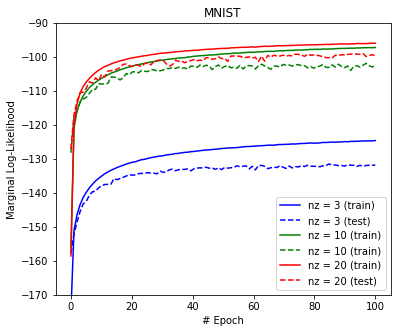

In [34]:
xs = np.linspace(0, 100, 100)
fig = plt.figure(figsize=(6,5))
ax = plt.axes()

ax.plot(xs, np.array(train_elbo_lst) * (-1), '-b')
ax.plot(xs, np.array(test_elbo_lst) * (-1), '--b')
ax.plot(xs, np.array(train_elbo_lst_10d) * (-1), '-g')
ax.plot(xs, np.array(test_elbo_lst_10d) * (-1), '--g')
ax.plot(xs, np.array(train_elbo_lst_20d) * (-1), '-r')
ax.plot(xs, np.array(test_elbo_lst_20d) * (-1), '--r')
ax.legend(("nz = 3 (train)","nz = 3 (test)", "nz = 10 (train)", "nz = 10 (train)",
          "nz = 20 (train)","nz = 20 (test)"))
ax.set(ylim = (-170, -90),
    title = "MNIST",
    xlabel = "# Epoch",
    ylabel = "Marginal Log-Likelihood")
pass

### Estimate ELBO
- For different training sample size

In [9]:
network_architecture = dict(n_hidden_enc_1=500, 
                             n_hidden_enc_2=500, 
                             n_hidden_dec_1=500, 
                             n_hidden_dec_2=500, 
                             n_input=784, 
                             n_z=20) 

vae1k, train_elbo_lst1k, test_elbo_lst1k = train_mnist_elbo(network_architecture, mnist.train_images()[:1000], 
                                                      mnist.test_images(), n_epoch = 100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch: 1/100 Train Loss = 416.7258 Test Loss = 254.2544
Epoch: 2/100 Train Loss = 227.2190 Test Loss = 218.9869
Epoch: 3/100 Train Loss = 210.5031 Test Loss = 211.5966
Epoch: 4/100 Train Loss = 205.1661 Test Loss = 207.8847
Epoch: 5/100 Train Loss = 202.5447 Test Loss = 204.9608
Epoch: 6/100 Train Loss = 199.0827 Test Loss = 201.2004
Epoch: 7/100 Train Loss = 195.2679 Test Loss = 198.0153
Epoch: 8/100 Train Loss = 191.9847 Test Loss = 194.8195
Epoch: 9/100 Train Loss = 187.4377 Test Loss = 189.4429
Epoch: 10/100 Train Loss = 180.8432 Test Loss = 182.9106
Epoch: 11/100 Train Loss = 173.9444 Test Loss = 178.0582
Epoch: 12/100 Train Loss = 169.2548 Test Loss = 174.4292
Epoch: 13/100 Train Loss = 165.7316 Test Loss = 171.6632
Epoch: 14/100 Train Loss = 162.6520 Test Loss = 169.3480
Epoch: 15/100 Train Loss = 159.4525 Test Loss = 165.8316
Epoch: 16/100 Train Loss = 155.6254 Test Loss = 162.3964
Epoch: 17/100 Tr

In [10]:
network_architecture = dict(n_hidden_enc_1=500, 
                             n_hidden_enc_2=500, 
                             n_hidden_dec_1=500, 
                             n_hidden_dec_2=500, 
                             n_input=784, 
                             n_z=20) 

vae50k, train_elbo_lst50k, test_elbo_lst50k = train_mnist_elbo(network_architecture, mnist.train_images()[:50000], 
                                                      mnist.test_images(), n_epoch = 100)

/Users/yizizhang/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 1/100 Train Loss = 163.7308 Test Loss = 128.5128
Epoch: 2/100 Train Loss = 123.0574 Test Loss = 117.0050
Epoch: 3/100 Train Loss = 115.6423 Test Loss = 112.1868
Epoch: 4/100 Train Loss = 112.1499 Test Loss = 110.0217
Epoch: 5/100 Train Loss = 109.9357 Test Loss = 108.2058
Epoch: 6/100 Train Loss = 108.4411 Test Loss = 107.4511
Epoch: 7/100 Train Loss = 107.3027 Test Loss = 106.2100
Epoch: 8/100 Train Loss = 106.1757 Test Loss = 106.0617
Epoch: 9/100 Train Loss = 105.5196 Test Loss = 104.6184
Epoch: 10/100 Train Loss = 104.7962 Test Loss = 104.8996
Epoch: 11/100 Train Loss = 104.2529 Test Loss = 104.0019
Epoch: 12/100 Train Loss = 103.7703 Test Loss = 103.3368
Epoch: 13/100 Train Loss = 103.2882 Test Loss = 103.4821
Epoch: 14/100 Train Loss = 102.9646 Test Loss = 102.6903
Epoch: 15/100 Train Loss = 102.5487 Test Loss = 102.4327
Epoch: 16/100 Train Loss = 102.2961 Test Loss = 102.6625
Epoch: 17/100 Train Loss = 101.9566 Test Loss = 102.4741
Epoch: 18/100 Train Loss = 101.6689 Test

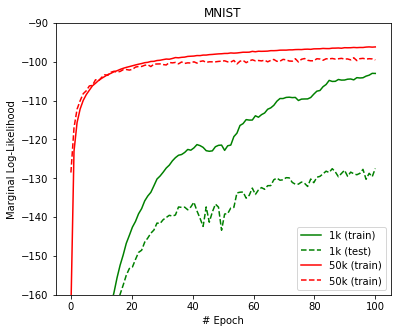

In [14]:
xs = np.linspace(0, 100, 100)
fig = plt.figure(figsize=(6,5))
ax = plt.axes()

ax.plot(xs, np.array(train_elbo_lst1k) * (-1), '-g')
ax.plot(xs, np.array(test_elbo_lst1k) * (-1), '--g')
ax.plot(xs, np.array(train_elbo_lst50k) * (-1), '-r')
ax.plot(xs, np.array(test_elbo_lst50k) * (-1), '--r')
ax.legend(("1k (train)","1k (test)", "50k (train)", "50k (train)"))
ax.set(ylim = (-160, -90),
    title = "MNIST",
    xlabel = "# Epoch",
    ylabel = "Marginal Log-Likelihood")
pass